In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
import getpass
%matplotlib inline

In [2]:
username = getpass.getuser()

In [3]:
data = pd.read_csv('/Users/{:}/Dropbox (HMS)/mouse_bandit/markov_full.csv'.format(username), index_col=0)
#data = data[data['Mouse ID']=='Baby']
data = data[data['Condition']=='70-30']
data.head()

,index,Mouse ID,Session ID,Trial,Block Trial,Block Reward,Port Streak,Reward Streak,10_Port,10_Reward,...,1_trialDuration,0_ITI,0_trialDuration,Decision,Switch,Higher p port,Reward,Condition,Block ID,Current Block Length
217080,0,Baby,01222018_Baby,11.0,11.0,3.0,1.0,1.0,0.0,0.0,...,0.533,1.222,0.267,1.0,0.0,1.0,1.0,70-30,1.0,15.0
217081,1,Baby,01222018_Baby,12.0,12.0,4.0,2.0,2.0,1.0,0.0,...,0.267,2.035,0.325,1.0,0.0,1.0,1.0,70-30,1.0,15.0
217082,2,Baby,01222018_Baby,13.0,13.0,5.0,3.0,3.0,1.0,1.0,...,0.325,1.579,0.597,1.0,0.0,1.0,0.0,70-30,1.0,15.0
217083,3,Baby,01222018_Baby,14.0,14.0,5.0,4.0,-1.0,1.0,0.0,...,0.597,2.327,0.452,1.0,0.0,1.0,0.0,70-30,1.0,15.0
217084,4,Baby,01222018_Baby,15.0,0.0,5.0,5.0,-2.0,0.0,0.0,...,0.452,1.524,0.569,1.0,0.0,0.0,0.0,70-30,2.0,20.0


### make some new dataframes
    X has predictor variables (choice and reward history for past n trials) relevant variables for logit model
    Y has dependent variable (choice on current trial)

In [4]:
#include past 10 choice and reward values (this is most convenient given the current data structure)
choice_history = []
reward_history = []
for col in data.columns:
    if '_Port' in col:
        choice_history.append(data[col][:])
    elif '_Reward' in col:
        reward_history.append(data[col][:])
        
choice_history = np.transpose(np.asarray(choice_history))
reward_history = np.transpose(np.asarray(reward_history))
switch_history = np.abs(np.diff(choice_history)) # right now just missing whether or not switched on n-10 trial

#current trial decision and outcome 
choice = []
reward = []
switch = []

for col in data.columns:
    if 'Decision' in col:
        #print(col)
        choice.append(data[col][:])
    elif 'Reward' in col:
        #print(col)
        reward.append(data[col][:])
    elif 'Switch' in col:
        switch.append(data[col][:])

choice = np.transpose(np.asarray(choice))
reward = np.transpose(np.asarray(reward))
switch = np.transpose(np.asarray(switch))

### set up which datasets will be predictor and target

In [5]:
# set up as X and Y for logistic regression (X contains all predictors)
X_choice = np.column_stack((choice_history, reward_history)) # n-1 to n-10 trial choices and outcomes
X_switch = np.column_stack((switch_history, reward_history[:,0:9])) # n-1 to n-10 trial switches and outcomes
X_choice_switch = np.column_stack((switch_history, choice_history[:,0:9], reward_history[:,0:9]))

Y_choice = choice.ravel() # current trial choices
Y_switch = switch.ravel() # current trial switches

### split data into training and testing datasets
--right now 70% to train, 30% test

--X (train and test) mxn matrix with m trials and [n/2 choice, n/2 corresponding reward outcomes]
            
            X[:,0:9] = choice_history
            
            X[:,10:19] = reward_history

--Y (train and test) mx1 matrix with m trials and 1 choice outcome


In [6]:
#train on proportion of data up to the 'cutoff.' hold out the rest as test data.
idx = np.random.permutation(len(X_choice))
cutoff = 0.7
idx_train = idx[0:int(len(X_choice)*cutoff)]
idx_test = idx[int(len(X_choice)*cutoff):]

X_train = X_choice[idx_train]
X_test = X_choice[idx_test]

Y_train_choice = Y_choice[idx_train]
Y_test_choice = Y_choice[idx_test]

Y_train_switch = Y_switch[idx_train]
Y_test_switch = Y_switch[idx_test]

### Logistic regression
Compare training on port choice (lr_port) vs training on switch (lr_switch)

### lr1 - train on port choice to predict port choice
#### Evaluate performance on predicting choice and predicting switches

In [7]:
lr1_choice = LogisticRegression()
lr1_choice.fit(X_train, Y_train_choice)

lr1_choice_proba = lr1_choice.predict_proba(X_test)
lr1_choice_predict = lr1_choice.predict(X_test)

score_lr1_choice = lr1_choice.score(X_test, Y_test_choice)
metrics_lr1_choice = sklearn.metrics.precision_recall_fscore_support(Y_test_choice, lr1_choice_predict)

#switch_true = np.abs([Y_test_choice[n] - X_test[n,9] for n in range(len(Y_test_choice))]) # actual switches from test port (n) vs n-1 port (test[i,9]) -- matches Y_test_switch
lr1_switch_predict = np.abs([lr1_choice_predict[n] - X_test[n,9] for n in range(len(lr1_choice_predict))])
metrics_lr1_switch = sklearn.metrics.precision_recall_fscore_support(Y_test_switch, lr1_switch_predict)


/Users/celiaberon/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [8]:
X_test.shape

(33033, 20)

In [9]:
'''
n_simulations = 10
cutoff = 0.7

def lr_bandit(X, y, n_simulations)

# select seed for each simulation
seed = np.random.randint(100000, size=n_simulations)

# initialize arrays for LR results
lr1_choice_predict = np.zeros((len(idx_test),n_simulations))
lr1_choice_proba = np.zeros((len(idx_test), 2))
lr1_score_choice = np.zeros(n_simulations)
lr1_metrics_full = np.zeros((4,2))

for i in range(n_simulations):
    np.random.seed(seed[i])
    idx = np.random.permutation(len(X_choice))
    idx_train = idx[0:int(len(X_choice)*cutoff)]
    idx_test = idx[int(len(X_choice)*cutoff):]

    X_train = X_choice[idx_train]
    X_test = X_choice[idx_test]

    Y_train_choice = Y_choice[idx_train]
    Y_test_choice = Y_choice[idx_test]
    Y_test_switch = Y_switch[idx_test]

    lr1_choice = LogisticRegression()
    lr1_choice.fit(X_train, Y_train_choice)

    lr1_choice_proba = np.dstack((lr1_choice_proba, lr1_choice.predict_proba(X_test)))
    lr1_choice_predict[:,i] = lr1_choice.predict(X_test)
    lr1_score_choice[i] = lr1_choice.score(X_test, Y_test_choice)
    
    lr1_switch_predict = np.abs([lr1_choice_predict[n] - X_test[n,9] for n in range(len(lr1_choice_predict))])
    lr1_metrics_switch = sklearn.metrics.precision_recall_fscore_support(Y_test_switch, lr1_switch_predict[:,i])
    lr1_metrics_full = np.dstack((lr1_metrics_full, np.array(lr1_metrics_switch)))

    
# clean up from initializing 3d stacks with zeros
lr1_metrics_full = lr1_metrics_full[:,:,1:n_simulations+1]
lr1_choice_proba = lr1_choice_proba[:,:,1:n_simulations+1]
'''

'\nn_simulations = 10\ncutoff = 0.7\n\ndef lr_bandit(X, y, n_simulations)\n\n# select seed for each simulation\nseed = np.random.randint(100000, size=n_simulations)\n\n# initialize arrays for LR results\nlr1_choice_predict = np.zeros((len(idx_test),n_simulations))\nlr1_choice_proba = np.zeros((len(idx_test), 2))\nlr1_score_choice = np.zeros(n_simulations)\nlr1_metrics_full = np.zeros((4,2))\n\nfor i in range(n_simulations):\n    np.random.seed(seed[i])\n    idx = np.random.permutation(len(X_choice))\n    idx_train = idx[0:int(len(X_choice)*cutoff)]\n    idx_test = idx[int(len(X_choice)*cutoff):]\n\n    X_train = X_choice[idx_train]\n    X_test = X_choice[idx_test]\n\n    Y_train_choice = Y_choice[idx_train]\n    Y_test_choice = Y_choice[idx_test]\n    Y_test_switch = Y_switch[idx_test]\n\n    lr1_choice = LogisticRegression()\n    lr1_choice.fit(X_train, Y_train_choice)\n\n    lr1_choice_proba = np.dstack((lr1_choice_proba, lr1_choice.predict_proba(X_test)))\n    lr1_choice_predict[:,i

In [10]:
'''
height_a = [np.mean(lr1_score_choice), np.mean(lr1_metrics_full[2,0,:]), np.mean(lr1_metrics_full[2,1,:])]
ystd1 = [np.std(lr1_score_choice), np.std(lr1_metrics_full[2,0,:]), np.std(lr1_metrics_full[2,1,:])]
yerr1 = [ystd1[i] / np.sqrt(n_simulations) for i in range(len(ystd1))]

barWidth = 0.3
# The x position of bars
r1 = np.arange(len(height_b))

conditions = ['full', 'stay', 'switch']
plt.bar(r1, height_a, width=barWidth, label='lr_choice', yerr=yerr1, capsize=3)

plt.xticks(range(len(height_b)), conditions)
plt.ylabel('accuracy (f1)')
plt.legend()
'''

"\nheight_a = [np.mean(lr1_score_choice), np.mean(lr1_metrics_full[2,0,:]), np.mean(lr1_metrics_full[2,1,:])]\nystd1 = [np.std(lr1_score_choice), np.std(lr1_metrics_full[2,0,:]), np.std(lr1_metrics_full[2,1,:])]\nyerr1 = [ystd1[i] / np.sqrt(n_simulations) for i in range(len(ystd1))]\n\nbarWidth = 0.3\n# The x position of bars\nr1 = np.arange(len(height_b))\n\nconditions = ['full', 'stay', 'switch']\nplt.bar(r1, height_a, width=barWidth, label='lr_choice', yerr=yerr1, capsize=3)\n\nplt.xticks(range(len(height_b)), conditions)\nplt.ylabel('accuracy (f1)')\nplt.legend()\n"

### lr2 - train on switches to predict switches

In [11]:
# redefine training and testing sets to use switch history and current switch decision
X = np.column_stack((switch_history, reward_history[:,0:8]))
X_train = X[idx_train]
X_test = X[idx_test]


# train and test LR
lr2_switch = LogisticRegression()
lr2_switch.fit(X_train, Y_train_switch)

lr2_switch_proba = lr2_switch.predict_proba(X_test)
lr2_switch_predict = lr2_switch.predict(X_test)

score_lr2_switch = lr2_switch.score(X_test, Y_test_switch)
metrics_lr2_switch = sklearn.metrics.precision_recall_fscore_support(Y_test_switch, lr2_switch_predict)


(array([  2.36200000e+04,   5.73200000e+03,   2.33700000e+03,
          8.28000000e+02,   3.20000000e+02,   1.17000000e+02,
          5.00000000e+01,   1.80000000e+01,   6.00000000e+00,
          5.00000000e+00]),
 array([ 0.02704244,  0.07435788,  0.12167332,  0.16898877,  0.21630421,
         0.26361966,  0.3109351 ,  0.35825055,  0.40556599,  0.45288143,
         0.50019688]),
 <a list of 10 Patch objects>)

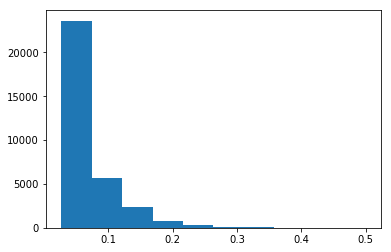

In [12]:
plt.hist(lr2_switch_proba[:,1])

### lr2.1 - change decision boundary

In [13]:
y_predict = np.zeros_like(lr2_switch_proba)
y_predict[lr2_switch_proba > 0.1] = 1

score_switch_2 = 1-(np.sum([np.abs(y_predict[i,1] - Y_test_switch[i]) for i in range(len(Y_test_switch))])/(len(Y_test_switch)))
switch_predict_2 = np.abs([y_predict[n,1] - X_test[n,8] for n in range(len(y_predict))])

metrics_switch_3 = sklearn.metrics.precision_recall_fscore_support(Y_test_switch, switch_predict_2)


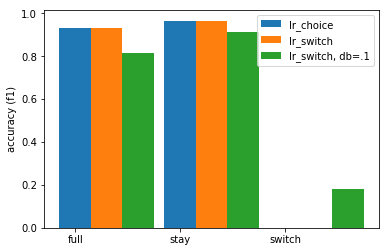

In [14]:
height_a = [score_lr1_choice, metrics_lr1_switch[2][0], metrics_lr1_switch[2][1]]
height_b = [score_lr2_switch, metrics_lr2_switch[2][0], metrics_lr2_switch[2][1]]
height_c = [score_switch_2, metrics_switch_3[2][0], metrics_switch_3[2][1]]

barWidth = 0.3
# The x position of bars
r1 = np.arange(len(height_b))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]


conditions = ['full', 'stay', 'switch']
plt.bar(r1, height_a, width=barWidth, label='lr_choice')
plt.bar(r2, height_b, width=barWidth, label='lr_switch')
plt.bar(r3, height_c, width=barWidth, label='lr_switch, db=.1')
plt.xticks(range(len(height_b)), conditions)
plt.ylabel('accuracy (f1)')
plt.legend()

### restructure dataset to reflect action value instead of raw actions

In [15]:
# value = L when choice = 0 and reward = 1 or when choice = 1 and reward = 0 
# value = R when choice = 1 and reward = 1 or when choice = 0 and reward = 0
value_history = (choice_history==reward_history).astype('int') # gives action value with R=1, L=0

### lr3 - use action value to predict choice

In [16]:
# redefine training set to use value history
X = value_history
X_train = X[idx_train]
X_test = X[idx_test]

# train and test LR
lr3_value = LogisticRegression()
lr3_value.fit(X_train, Y_train_choice)

lr3_value_proba = lr3_value.predict_proba(X_test)
lr3_value_predict = lr3_value.predict(X_test)

score_lr3_value_choice = lr3_value.score(X_test, Y_test_choice)
metrics_lr3_value = sklearn.metrics.precision_recall_fscore_support(Y_test_choice, lr3_value_predict)

lr3_switch_predict = np.abs([lr3_value_predict[n] - X_test[n,8] for n in range(len(lr3_value_predict))])
metrics_lr3_switch = sklearn.metrics.precision_recall_fscore_support(Y_test_switch, lr3_switch_predict)

score_switch_2 = 1-(np.sum([np.abs(lr3_value_predict[i] - Y_test_switch[i]) for i in range(len(Y_test_switch))])/(len(Y_test_switch)))


In [17]:
np.sum(switch_predict_2)

4058.0

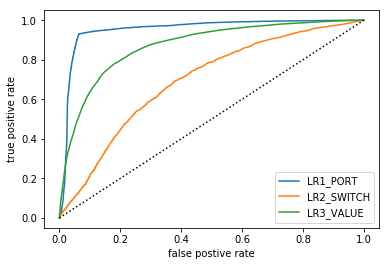

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(Y_test_choice, lr1_choice_proba[:,1])
plt.plot(fpr, tpr, label="LR1_PORT")

fpr, tpr, _ = roc_curve(Y_test_switch, lr2_switch_proba[:,1])
plt.plot(fpr, tpr, label="LR2_SWITCH")

fpr, tpr, _ = roc_curve(Y_test_choice, lr3_value_proba[:,1])
plt.plot(fpr, tpr, label="LR3_VALUE")

plt.plot([0, 1], [0, 1], ':k')
plt.xlabel('false postive rate')
plt.ylabel('true positive rate')

plt.legend(loc='lower right')

### what about a logistic regression with more inputs?

In [19]:
#train on proportion of data up to the 'cutoff.' hold out the rest as test data.
X_train = X_choice_switch[idx_train]
X_test = X_choice_switch[idx_test]

# train and test LR
lr4_multi = LogisticRegression()
lr4_multi.fit(X_train, Y_train_choice)

lr4_multi_proba = lr4_multi.predict_proba(X_test)
lr4_multi_predict = lr4_multi.predict(X_test)

score_lr4_multi_choice = lr4_multi.score(X_test, Y_test_choice)
metrics_lr4_choice = sklearn.metrics.precision_recall_fscore_support(Y_test_choice, lr4_multi_predict)

lr4_switch_predict = np.abs([lr4_multi_predict[n] - X_test[n,8] for n in range(len(lr4_multi_predict))])
metrics_lr4_switch = sklearn.metrics.precision_recall_fscore_support(Y_test_switch, lr4_switch_predict)

score_switch_2 = 1-(np.sum([np.abs(lr4_multi_predict[i] - Y_test_switch[i]) for i in range(len(Y_test_switch))])/(len(Y_test_switch)))

'''
Now train to predict switches
'''

lr5_multi = LogisticRegression()
lr5_multi.fit(X_train, Y_train_switch)

lr5_multi_proba = lr5_multi.predict_proba(X_test)
lr5_multi_predict = lr5_multi.predict(X_test)

score_lr5_multi_switch = lr5_multi.score(X_test, Y_test_switch)
metrics_lr5_switch = sklearn.metrics.precision_recall_fscore_support(Y_test_switch, lr5_multi_predict)


In [20]:
metrics_lr5_switch

(array([ 0.93384401,  0.        ]),
 array([ 0.99983791,  0.        ]),
 array([ 0.96571482,  0.        ]),
 array([30848,  2185]))

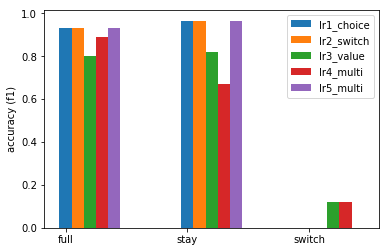

In [21]:
height_a = [score_lr1_choice, metrics_lr1_switch[2][0], metrics_lr1_switch[2][1]]
height_b = [score_lr2_switch, metrics_lr2_switch[2][0], metrics_lr2_switch[2][1]]
height_c = [score_lr3_value_choice, metrics_lr3_switch[2][0], metrics_lr3_switch[2][1]]
height_d = [score_lr4_multi_choice, metrics_lr4_switch[2][0], metrics_lr4_switch[2][1]]
height_e = [score_lr5_multi_switch, metrics_lr5_switch[2][0], metrics_lr5_switch[2][1]]


barWidth = 0.1
# The x position of bars
r1 = np.arange(len(height_b))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]



conditions = ['full', 'stay', 'switch']
plt.bar(r1, height_a, width=barWidth, label='lr1_choice')
plt.bar(r2, height_b, width=barWidth, label='lr2_switch')
plt.bar(r3, height_c, width=barWidth, label='lr3_value')
plt.bar(r4, height_d, width=barWidth, label='lr4_multi')
plt.bar(r5, height_e, width=barWidth, label='lr5_multi')



plt.xticks(range(len(height_b)), conditions)
plt.ylabel('accuracy (f1)')
plt.legend()

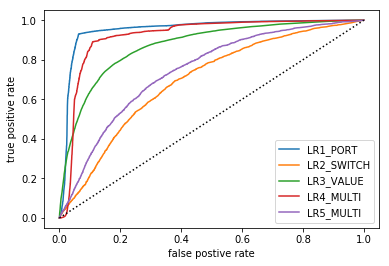

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(Y_test_choice, lr1_choice_proba[:,1])
plt.plot(fpr, tpr, label="LR1_PORT")

fpr, tpr, _ = roc_curve(Y_test_switch, lr2_switch_proba[:,1])
plt.plot(fpr, tpr, label="LR2_SWITCH")

fpr, tpr, _ = roc_curve(Y_test_choice, lr3_value_proba[:,1])
plt.plot(fpr, tpr, label="LR3_VALUE")

fpr, tpr, _ = roc_curve(Y_test_choice, lr4_multi_proba[:,1])
plt.plot(fpr, tpr, label="LR4_MULTI")

fpr, tpr, _ = roc_curve(Y_test_switch, lr5_multi_proba[:,1])
plt.plot(fpr, tpr, label="LR5_MULTI")

plt.plot([0, 1], [0, 1], ':k')
plt.xlabel('false postive rate')
plt.ylabel('true positive rate')

plt.legend(loc='lower right')